#1. Load Data and Perform EDA

   referral_friends  water_sources  shelters fauna_friendly  island_size  \
0               3.0            2.0       2.0      Cats,Dogs        892.0   
1               2.0            2.0       3.0            NaN       1322.0   
2               2.0            2.0       NaN            NaN       1204.0   
3               1.0            1.0       1.0      Cats,Dogs        558.0   
4               1.0            NaN       NaN      Cats,Dogs        670.0   

   creation_time region happiness_metric  \
0   1.568754e+09     TX          Monthly   
1   1.553720e+09     PA          Monthly   
2            NaN     NV          Monthly   
3   1.568755e+09    NaN          Monthly   
4   1.568772e+09     CA          Monthly   

                                            features  happiness_index  \
0  AC,Clubhouse,Fireplace,Parking,Patio/Deck,Play...           1014.0   
1                                            Parking           2700.0   
2  AC,Cable or Satellite,Clubhouse,Dishwasher,Fir...       

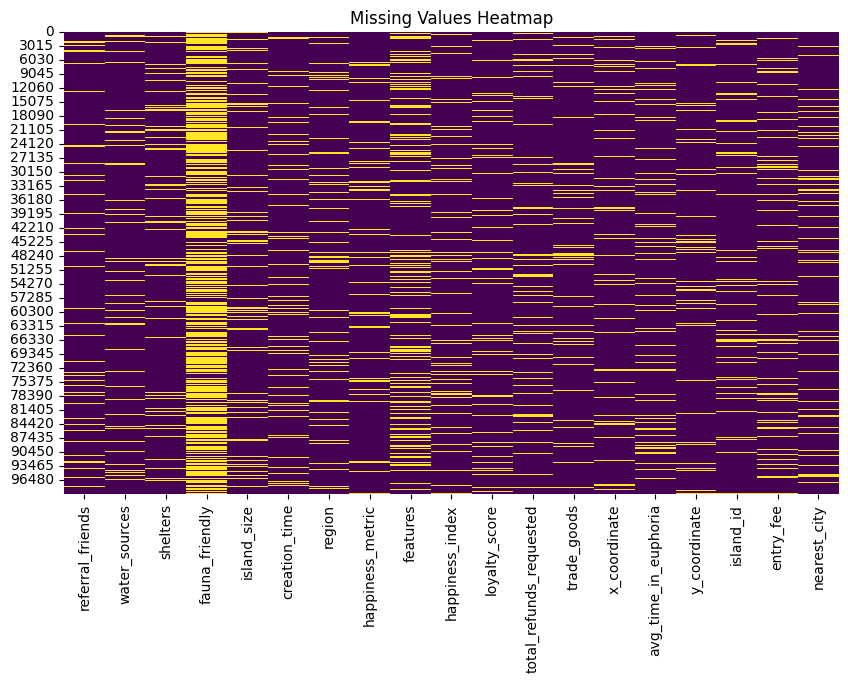

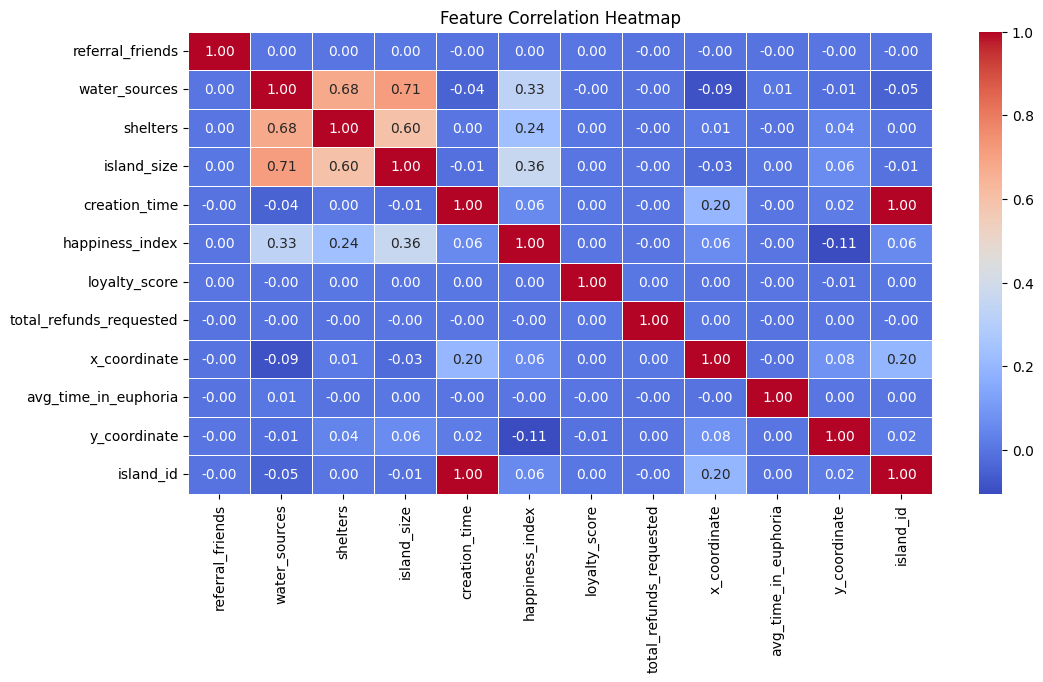

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("euphoria.csv")

# Display first few rows
print(df.head())

# Check data info and missing values
print(df.info())
print(df.isnull().sum())

# Summary statistics
print(df.describe())

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

# Correlation heatmap
# Select only numerical features for correlation calculation
numerical_df = df.select_dtypes(include=np.number)

plt.figure(figsize=(12, 6))
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

#2. Data Preprocessing
This handles missing values, outliers, encoding, and scaling.

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Drop irrelevant columns
df.drop(columns=['island_id', 'creation_time'], inplace=True)

# Fill missing numerical values with median
numerical_cols = df.select_dtypes(include=np.number).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Encode categorical features
categorical_cols = ['region', 'nearest_city', 'fauna_friendly']
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Remove outliers using IQR
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Scale numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("Data Preprocessing Completed ")
print(df.head())


Data Preprocessing Completed 
   referral_friends  water_sources  shelters  fauna_friendly  island_size  \
0          1.824115       1.323825  0.496642               1    -0.045137   
1          0.701120       1.323825  2.084319               4     1.772848   
2          0.701120       1.323825  0.496642               4     1.273959   
3         -0.421874      -0.730963 -1.091035               1    -1.457246   
4         -0.421874      -0.730963  0.496642               1    -0.983724   

   region happiness_metric                                           features  \
0      43          Monthly  AC,Clubhouse,Fireplace,Parking,Patio/Deck,Play...   
1      38          Monthly                                            Parking   
2      33          Monthly  AC,Cable or Satellite,Clubhouse,Dishwasher,Fir...   
3      51          Monthly  AC,Dishwasher,Fireplace,Gated,Gym,Patio/Deck,Pool   
4       4          Monthly      AC,Gated,Internet Access,Parking,Pool,Storage   

   happiness_index  

<ipython-input-4-bdba55129fc7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Drop non-numeric columns
non_numeric_cols = ['happiness_metric', 'features', 'trade_goods', 'entry_fee']
df.drop(columns=non_numeric_cols, inplace=True, errors='ignore')

# Encode categorical features
categorical_cols = ['region', 'nearest_city', 'fauna_friendly', 'payment_frequency']
for col in categorical_cols:
    if col in df.columns:
        if col == 'payment_frequency':
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            encoded_data = encoder.fit_transform(df[[col]])
            encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([col]), index=df.index)
            df = pd.concat([df, encoded_df], axis=1).drop(columns=[col])
        else:
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Scale numerical features
numerical_cols = df.select_dtypes(include=np.number).columns
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Select features for clustering
features = df.drop(columns=['happiness_index'], errors='ignore')

df.to_csv("processed_data.csv", index=False)
print(" Data preprocessing complete!")


 Data preprocessing complete!


#3. Clustering Models
**This is a clustering problem because there are no predefined labels, and the goal is to group similar data points based on their features. Models like K-Means, MiniBatch K-Means, and DBSCAN identify natural patterns in the data rather than making predictions.**

K-Means Clustering

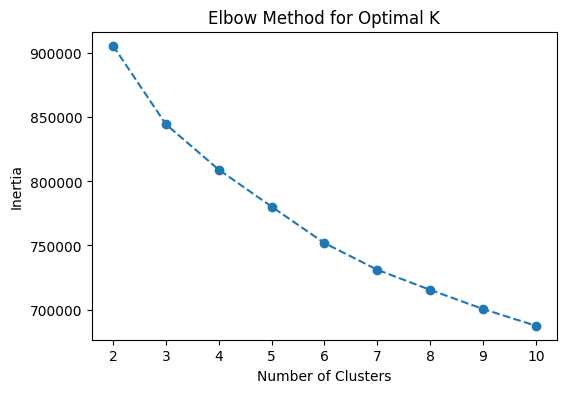

K-Means clustering complete! 


In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load preprocessed data
df = pd.read_csv("processed_data.csv")
features = df.drop(columns=['happiness_index'], errors='ignore')

# Elbow Method for Optimal k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(6, 4))
plt.plot(range(2, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Fit K-Means with best k
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans.fit_predict(features)

# Save results
df.to_csv("kmeans_results.csv", index=False)
print("K-Means clustering complete! ")


MiniBatch K-Means

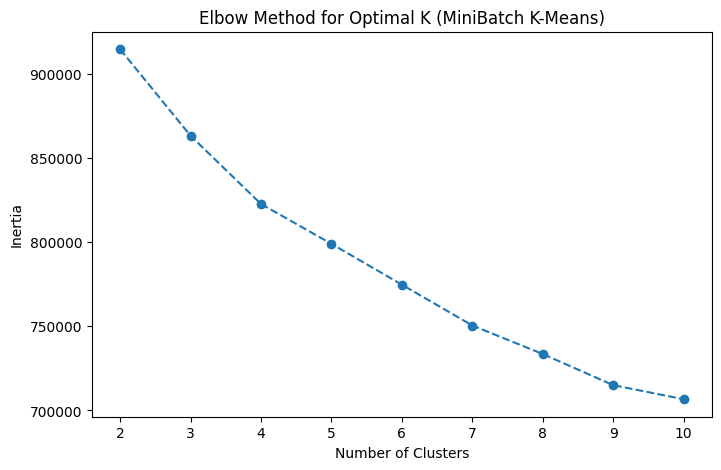

 MiniBatch K-Means clustering complete!


In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import pandas as pd

# Load preprocessed data
df = pd.read_csv("processed_data.csv")
features = df.drop(columns=['happiness_index'], errors='ignore')


# Find optimal k using Elbow Method
inertia = []
for k in range(2, 11):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K (MiniBatch K-Means)')
plt.show()

# Train MiniBatch K-Means with optimal k
optimal_k = 4
mb_kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=100)
df['cluster'] = mb_kmeans.fit_predict(features)

print(" MiniBatch K-Means clustering complete!")

DBSCAN Clustering

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Load preprocessed data
df = pd.read_csv("processed_data.csv")
features = df.drop(columns=['happiness_index'], errors='ignore')

# Fit DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(features)

# Compute silhouette score
valid_clusters = df['dbscan_cluster'] != -1
if valid_clusters.sum() > 1:
    dbscan_silhouette = silhouette_score(features[valid_clusters], df[valid_clusters]['dbscan_cluster'])
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.3f}")
else:
    print("DBSCAN found mostly noise, try reducing eps or min_samples.")

# Save results
df.to_csv("dbscan_results.csv", index=False)
print("DBSCAN clustering complete!")


DBSCAN Silhouette Score: -0.220
DBSCAN clustering complete!


#4. Train & Evaluate Models

In [9]:
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Define optimal K
optimal_k = 4

# Train Standard K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans.fit_predict(features)

# Train MiniBatch K-Means
mb_kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=100)
df['mb_kmeans_cluster'] = mb_kmeans.fit_predict(features)

# Train DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(features)

# Evaluate Clustering using Silhouette Score
kmeans_silhouette = silhouette_score(features, df['kmeans_cluster'])
mb_kmeans_silhouette = silhouette_score(features, df['mb_kmeans_cluster'])

if len(set(df['dbscan_cluster'])) > 1:
    dbscan_silhouette = silhouette_score(features, df['dbscan_cluster'])
else:
    dbscan_silhouette = None

# Print evaluation metrics
print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")
print(f"MiniBatch K-Means Silhouette Score: {mb_kmeans_silhouette:.4f}")
if dbscan_silhouette:
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")
else:
    print("DBSCAN produced only one cluster, silhouette score not applicable.")


K-Means Silhouette Score: 0.0968
MiniBatch K-Means Silhouette Score: 0.0833
DBSCAN Silhouette Score: -0.4635


#5. Report and Summary

In [10]:
# Count clusters in each method
kmeans_counts = df['kmeans_cluster'].value_counts().sort_index()
mb_kmeans_counts = df['mb_kmeans_cluster'].value_counts().sort_index()
dbscan_counts = df['dbscan_cluster'].value_counts().sort_index()

# Print cluster distributions
print("\nK-Means Cluster Distribution:\n", kmeans_counts)
print("\nMiniBatch K-Means Cluster Distribution:\n", mb_kmeans_counts)
print("\nDBSCAN Cluster Distribution:\n", dbscan_counts)

# Summary Report
print("\n=== Clustering Summary ===")
print(f"K-Means - Clusters: {optimal_k}, Silhouette Score: {kmeans_silhouette:.4f}")
print(f"MiniBatch K-Means - Clusters: {optimal_k}, Silhouette Score: {mb_kmeans_silhouette:.4f}")
if dbscan_silhouette:
    print(f"DBSCAN - Found {len(set(df['dbscan_cluster']))} clusters, Silhouette Score: {dbscan_silhouette:.4f}")
else:
    print("DBSCAN did not identify multiple clusters.")



K-Means Cluster Distribution:
 kmeans_cluster
0    17041
1    20278
2    19788
3    31266
Name: count, dtype: int64

MiniBatch K-Means Cluster Distribution:
 mb_kmeans_cluster
0    15534
1    17886
2    31046
3    23907
Name: count, dtype: int64

DBSCAN Cluster Distribution:
 dbscan_cluster
-1      87529
 0         82
 1          7
 2         31
 3          7
        ...  
 101        5
 102        7
 103        6
 104        6
 105        5
Name: count, Length: 107, dtype: int64

=== Clustering Summary ===
K-Means - Clusters: 4, Silhouette Score: 0.0968
MiniBatch K-Means - Clusters: 4, Silhouette Score: 0.0833
DBSCAN - Found 107 clusters, Silhouette Score: -0.4635
